# Forecast test code

<!-- **source codes are under /src** -->

owner: Yi Ju. last updated: 2023/02/16

**contact the owner before you edit this notebook (incl. run)**

**AND very clearly mark where you edit (and why)**

<!-- ### Debug tips
you can check `mpc.cache` to find the last state before bug occurs -->

In [1]:
import os
import sys
src_path = sys.path[0].replace("notebooks", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("notebooks", "output")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import torch
from datetime import datetime, timedelta
import time

from data_loader import UCSD_dataloader
from data_pool import DataPool

In [3]:
loader = UCSD_dataloader
loaded = loader(tstart=datetime(2019,1,1,0,0), tend=datetime(2020,1,1,0,0), delta=0.25,
    bld="Hopkins", pv="Hopkins", ev="OSLER", pv_to_bld=0.5, ev_to_bld=0.2, Pmax=10)
data = loaded.get_data()

In [4]:
ev_sessions = data["ev_sessions"]
t = datetime(2019, 12, 20, 0, 0)

In [1]:
"""
1. forecast model for building load
input: 
    (1) prev 72 hours data
    (2) hour, mimnute, day in week, month
output: 
    next 24 hour data
model
    (1) LSTM
    (2) XGBoost

2. forecast model for PV

3. froecast model for EV
"""

'\n1. forecast model for building load\ninput: \n    (1) prev 72 hours data\n    (2) hour, mimnute, day in week, month\noutput: \n    next 24 hour data\nmodel\n    (1) LSTM\n    (2) XGBoost\n\n2. forecast model for PV\n\n3. froecast model for EV\n'

In [85]:
data = loaded.get_data()
dp = DataPool(data)

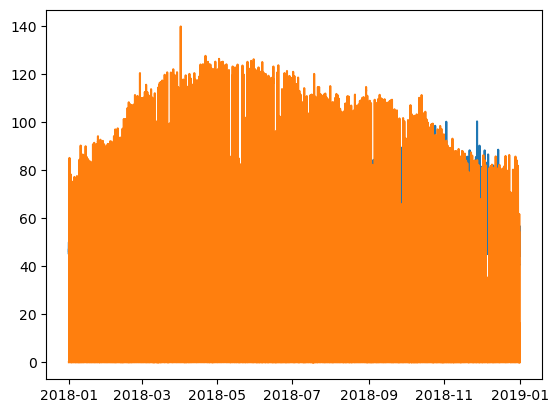

In [86]:
plt.plot(data["load_bld"])
plt.plot(data["load_pv"])

In [87]:
load_data = pd.DataFrame(data["load_bld"])

In [171]:
delta = 0.25
prev_hr = 36
fore_hr = 12

input_seq_len = int(prev_hr/delta)
output_seq_len = int(fore_hr/delta)

data_lstm = pd.DataFrame(
    index = load_data.index,
    columns=range(input_seq_len, output_seq_len))
data_lstm[0] = load_data[0]

In [183]:
for i in range(input_seq_len):
    data_lstm[-i-1] = data_lstm[0].shift(i)
for i in range(output_seq_len):
    data_lstm[i] = data_lstm[0].shift(-i-1)

np_lstm = data_lstm.dropna().values

input = np_lstm[:, :input_seq_len]  # (T, input_seq_len)
label = np_lstm[:,input_seq_len:]  # (T, output_seq_len)

In [184]:
input_dim = int(input_seq_len / output_seq_len)
input = np.stack(
    [input[:,i*output_seq_len:(i+1)*output_seq_len] for i in range(input_dim)],
    axis=-1) # (T, output_seq_len, input_dim)

label = label[:,:,None] # (T, output_seq_len, 1)

In [191]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [186]:
hidden_dim = 16
output_dim = 1
num_layers = 1

lstm_layer = nn.LSTM(
    input_size = input_dim,
    hidden_size = hidden_dim,
    num_layers = num_layers,
    proj_size = output_dim,
    batch_first = True
)

In [187]:
input_torch = torch.from_numpy(input).float() # (T, output_seq_len, input_dim)
label_torch = torch.from_numpy(label).float() # (T, output_seq_len, 1)

In [188]:
batch_size = 512

# hidden_state = torch.randn(1, batch_size, output_dim)
# cell_state = torch.randn(1, batch_size, hidden_dim)
# hidden = (hidden_state, cell_state)

In [193]:
train_data = TensorDataset(input_torch, label_torch)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [194]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [197]:
# write the model tomorrow

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [190]:
out.shape

torch.Size([512, 48, 1])